In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'D:\\Anaconda3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX', 'TSLA']:
#     if symbol == 'SHPG':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [35]:
%%time

### 时间设置
start_date = '2008-06-02'
# start_date = '2010-01-01'
# start_date = '2017-01-03'
# start_date = '2018-01-01'
end_date = '2018-06-06'

TURTLE_POS = 20
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 20
TURTLE_LONG_SELL_N = 20

### 业务设置
is_happy_money = False
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY

Wall time: 0 ns


In [20]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
#     stock_df['c_pct_chg'] = stock_df.close.pct_change(1)
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    
    # Turtle指标
    stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
    stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
    stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
    stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
    stock_df['N'] = stock_df['TR'].rolling(20).mean()
    stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
    stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['MA%d' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).mean()
#     stock_df['MA%d' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).mean()
    stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
    stock_df['MA360'] = stock_df['open'].rolling(360).mean()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    
#     stock_df['ops'] = ''
#     stock_df['profit'] = 0
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
    stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 26.7 s


In [5]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [30, 20]

# df = stock_df_dict['HAS'].iloc[0:800].copy()
# df
# # df[(df.open == df.rolling_60_max)]
# # df[(df.open >= df.rolling_60_max) & (df.MA30 > df.MA60)]
# # df[(df.MA30 > df.MA60)]

# df = df.loc[:, ['open', 'rolling_60_max', 'rolling_30_min', 'MA60', 'MA30']]

# df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
# df.set_index('date', inplace=True)
# df.index.astype()

# from pandas.compat import StringIO
# data = """Date,Value\n2019-12-31,1.7\n2018-12-31,1.7\n2017-12-31,1.7\n2016-12-31,1.5\n2015-12-31,1.247\n2014-12-31,0.896\n2013-12-31,1.601\n2012-12-31,2.13\n2011-12-31,2.498\n2010-12-31,1.158\n2009-12-31,0.226\n2008-12-31,2.738\n2007-12-31,2.285\n2006-12-31,1.784\n2005-12-31,1.92\n2004-12-31,1.799\n2003-12-31,1.022\n2002-12-31,1.346\n2001-12-31,1.904\n2000-12-31,1.418\n1999-12-31,0.626\n1998-12-31,0.593\n1997-12-31,1.542\n1996-12-31,1.19\n1995-12-31,1.733\n1994-12-31,2.717\n1993-12-31,4.476\n1992-12-31,5.046\n1991-12-31,3.474\n1990-12-31,2.687\n1989-12-31,2.778\n1988-12-31,1.274\n1987-12-31,0.242\n1986-12-31,-0.125\n1985-12-31,2.084\n1984-12-31,2.396\n1983-12-31,3.284\n1982-12-31,5.256\n1981-12-31,6.324\n1980-12-31,5.447\n"""
# df = pd.read_csv(StringIO(data), index_col=0, parse_dates=True)
# # df
# df.index

# display_charts(df, chart_type='stock', kind='line', y=['open', 'rolling_max', 'rolling_min'], figsize=(900, 600), logy=False)

# display_charts(df)
# ax = df.plot(kind='line', y=['open', 'rolling_max', 'rolling_min'], label='', linewidth=1)

sum_buy_sig_short = 0
sum_buy_sig_long = 0
for symbol in NASDAQ100:
    tdf = stock_df_dict[symbol]
    buy_sig_short = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N])]
    buy_sig_long = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N])]
    buy_sig_short_2 = buy_sig_short[buy_sig_short.MA30 >= buy_sig_short.MA180]
    buy_sig_long_2 = buy_sig_long[buy_sig_long.MA30 >= buy_sig_long.MA180]
#     print(symbol, len(tdf), len(buy_sig_short), len(buy_sig_short_2), len(buy_sig_long), len(buy_sig_long_2))
    sum_buy_sig_short += len(buy_sig_short_2)
    sum_buy_sig_long += len(buy_sig_long_2)
# print(len(stock_df_dict['NDX']), sum_buy_sig_short, sum_buy_sig_long)

In [6]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 0 ns


In [36]:
%%time
# %xmode

PROPERTY = START_MONEY
CASH = START_MONEY

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])
count_day = 0
yesterday = None

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > START_MONEY * 2:
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    # 买卖过程
    for symbol in NASDAQ100[:]:
#     for symbol in ['TSLA']:
        if symbol in ['ALGN', 'ROST', 'ORLY', 'ESRX', 'ULTA', 'REGN', 'MNST']:
#             continue
            pass

        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
#         print(order_df)
#         print(order_df.columns)
        
#         %timeit (len(order_df[order_df['symbol'] == symbol]) != 0)
#         %timeit order_df[order_df['symbol'] == symbol].shape[0] != 0
#         %timeit n_order_df = order_df.values
#         %timeit len(n_order_df[n_order_df[:, 1] == symbol]) != 0
#         %timeit (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)


#         iiidx = stock_df_dict[symbol].index.get_loc(today)
#         print(iiidx, type(iiidx))
#         %timeit stock_df_dict[symbol].loc[today]
#         %timeit n_stock_df = stock_df_dict[symbol].values
#         %timeit n_stock_df[iiidx]
        
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])

#         %timeit int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#         %timeit int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#         %timeit buy_count * stock_df_dict[symbol].loc[today, 'open']
#         %timeit stock_df_dict[symbol]
#         %timeit stock_df_dict[symbol].loc[today, 'open']
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] > order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].buy_price.iloc[-1] + 0.5 * stock_df_dict[symbol].shift(1).loc[today, 'N'])
        
#         n_order_df = order_df.values
#         n_stock_df = stock_df_dict[symbol].values
#         today_idx = stock_df_dict[symbol].index.get_loc(today)
#         is_has_order = (len(n_order_df[n_order_df[:, 1] == symbol]) != 0)
#         is_order_soldout = not is_has_order and (len(n_order_df[n_order_df[:, 6] == symbol]) == 0)
        
#         is_has_order = (len(order_df[order_df['symbol'] == symbol]) != 0)
#         is_order_soldout = (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)
        
    
#         '''
#         'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
#         stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
#         stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#         '''
        
        # 突破下行趋势，清仓退出
        order_arr = order_df.to_records(index=False)
        if len(order_arr[(order_arr.symbol == symbol) & (order_arr.sell_price == 0)] ) != 0:
            is_sell = False
            for idx in order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].index:
                if order_df.loc[idx, 'buy_reason'] == 'SHORT':
                    is_sell = (stock_df_dict[symbol].loc[today, 'open'] <= stock_df_dict[symbol].loc[today, 'ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
                if order_df.loc[idx, 'buy_reason'] == 'LONG':
                    is_sell = (stock_df_dict[symbol].loc[today, 'open'] <= stock_df_dict[symbol].loc[today, 'ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                if is_sell:
                    CASH += order_df.loc[idx, 'buy_count'] * stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)


        # 突破上行趋势，就买一份
        order_arr = order_df.to_records(index=False)
        if stock_df_dict[symbol].loc[today, 'MA30'] >= stock_df_dict[symbol].loc[today, 'MA180']:
            is_buy = False
            if stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                is_buy = True
                buy_reason = 'LONG'
            elif False and stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'
            if is_buy:
                buy_count = 0
#                 buy_count = min(
#                     int(stock_df_dict[symbol].shift(1).loc[today, 'Unit']),
#                     int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#                 )
#                 print(symbol, today)
#                 buy_count = int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#                 buy_count = int(min(PROPERTY / TURTLE_POS, CASH) / stock_df_dict[symbol].loc[today, 'open'])
                if CASH > START_MONEY / TURTLE_POS:
                    buy_count = int((START_MONEY / TURTLE_POS) / stock_df_dict[symbol].loc[today, 'open'])
#                 if buy_count > int(CASH / stock_df_dict[symbol].loc[today, 'open']):
#                     buy_count = 0
#                 buy_count = 1
                if buy_count > 0:
                    CASH -= buy_count * stock_df_dict[symbol].loc[today, 'open']
#                     print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                    order_df = order_df.append(
                        {
                            'buy_date': today,
                            'symbol': symbol,
                            'buy_count': buy_count,
                            'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                            'buy_reason': buy_reason,
                            'sell_date': pd.np.nan,
                            'sell_price': 0,
                            'profit': 0,
                            'cash': CASH,
                            'property': PROPERTY,
                        },
                        ignore_index=True
                    )
            
    # 每天盘点财产
    show_df.loc[today, 'CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)

s_p = stock_df_dict['NDX'][start_date:].iloc[0].open
e_p = stock_df_dict['NDX'].iloc[-1].open
print('NDX', s_p, e_p, e_p / s_p)


3059.4887999997445
0
317256.4279999998
NDX 1743.55 7212.431 4.136635599782053
Wall time: 11min 1s


In [8]:
# 165 * 220
# 25197.25 / 228.97

# buy_count = min(
#                     int(stock_df_dict['TSLA'].loc['2017-09-18', 'Unit']),
#                     int(16100.17 / stock_df_dict['TSLA'].loc['2017-09-19', 'open'])
#                 )
# int(stock_df_dict['TSLA'].loc['2017-09-18', 'Unit'])
# int(16100.17 / stock_df_dict['TSLA'].loc['2017-09-19', 'open'])
# buy_count

# pd.reset_option("display.max_rows")
# order_df

# order_df[(order_df['symbol'] == 'TSLA') & (order_df['sell_price'] == 0)]
# pd.options.display.max_rows = 999
# stock_df_dict['TSLA'].loc[start_date:]

In [9]:
'ALL'
'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
'REWARD', ((sum_profit - sum_tax) / START_MONEY + 1) ** (365 / count_day)
len(order_df[order_df.profit != 0])
len(order_df[order_df.profit > 0])
len(order_df[order_df.buy_reason == 'LONG'])
len(order_df[(order_df.buy_reason == 'LONG') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'LONG']['profit']))
len(order_df[order_df.buy_reason == 'SHORT'])
len(order_df[(order_df.buy_reason == 'SHORT') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'SHORT']['profit']))

# order_df
# order_df.loc[order_df['sell_price']==0]

calc_df = order_df.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
# calc_df[calc_df.symbol == 'BIDU']
# calc_df[calc_df.profit > 0]
calc_df

# order_df[order_df.profit > 0]

# csv_file = 'E:/Dev/result/T_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

'ALL'

('len(order_df)', 377)

('sum_profit', 325460.91349999997)

('sum_tax', 0)

('win rate', 0.5343283582089552)

('REWARD', 1.1554884120112177)

335

179

377

179

325460.91349999997

0

0

0

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property,profit_pct
0,2009-11-10,ADBE,273,36.5600,LONG,2010-02-01,32.39,EXIT,-1138.41,90019.1200,100000,-0.114059
1,2009-11-10,GOOGL,35,284.2602,LONG,2010-02-01,270.051,EXIT,-497.305,80070.0130,100000,-0.0499848
2,2009-11-10,ADSK,363,27.5200,LONG,2010-02-05,23.07,EXIT,-1615.35,70080.2530,100000,-0.161701
3,2009-11-10,ADP,266,37.4556,LONG,2010-02-04,35.6536,EXIT,-479.332,60117.0634,100000,-0.0481103
4,2009-11-10,BKNG,51,194.9200,LONG,2010-05-14,208.86,EXIT,710.94,50176.1434,100000,0.0715165
5,2009-11-10,CHKP,307,32.4800,LONG,2010-05-07,32.38,EXIT,-30.7,40204.7834,100000,-0.00307882
6,2009-11-10,CTSH,455,21.9355,LONG,2010-02-05,21.5,EXIT,-198.153,30224.1309,100000,-0.0198537
7,2009-11-10,COST,166,59.9200,LONG,2010-05-07,57.86,EXIT,-341.96,20277.4109,100000,-0.0343792
8,2009-11-10,CTRP,631,15.8375,LONG,2010-02-05,14.975,EXIT,-544.238,10283.9484,100000,-0.0544594
9,2009-11-10,ESRX,232,43.0500,LONG,2010-06-29,48.55,EXIT,1276,296.3484,100000,0.127758


In [10]:
bad_stock_cnt = 0
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)
    if e_p / s_p < 3.89704671:
        bad_stock_cnt += 1
bad_stock_cnt


54

In [11]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# order_df_TB
bar_df = order_df.copy()
df = bar_df.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-200, 500)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

# display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600), logy=True)

Index(['close', 'UNIT', 'ROLLING_20_MAX', 'ROLLING_20_MIN', 'ROLLING_60_MAX',
       'ROLLING_60_MIN', 'EWMA', 'MA360', 'MA180', 'MA30',
       'CASH_TURTLE_10_60_60', 'PROPERTY_TURTLE_10_60_60',
       'CASH_TURTLE_20_60_60', 'PROPERTY_TURTLE_20_60_60',
       'CASH_TURTLE_50_60_60', 'PROPERTY_TURTLE_50_60_60',
       'CASH_TURTLE_50_40_40', 'PROPERTY_TURTLE_50_40_40',
       'CASH_TURTLE_20_40_40', 'PROPERTY_TURTLE_20_40_40',
       'CASH_TURTLE_10_40_40', 'PROPERTY_TURTLE_10_40_40',
       'CASH_TURTLE_10_20_20', 'PROPERTY_TURTLE_10_20_20',
       'CASH_TURTLE_50_20_20', 'PROPERTY_TURTLE_50_20_20',
       'CASH_TURTLE_20_20_20', 'PROPERTY_TURTLE_20_20_20'],
      dtype='object')

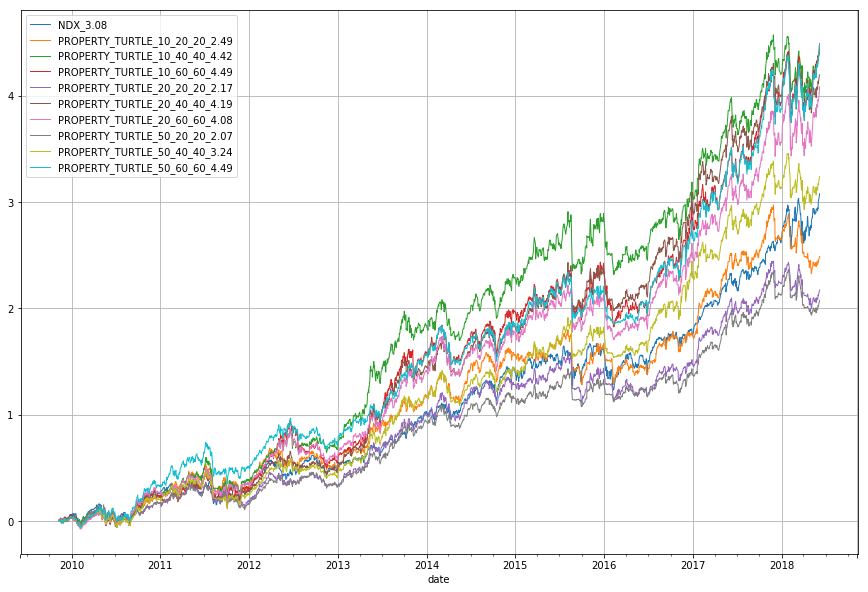

In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()
df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df.columns

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='NDX_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)